# MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target

X.shape, y.shape

((70000, 784), (70000,))

In [5]:
28 * 28

784

In [6]:
mnist.categories

{'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

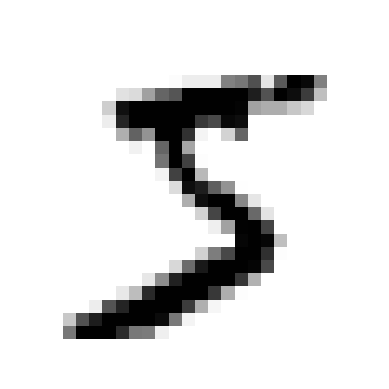

In [7]:
import matplotlib.pyplot as plt


def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## Training a Binary Classifier

In [10]:
y_train_5 = y_train == "5"
y_test_5 = y_test == "5"

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

`cross_val_score` fn evaluate a model using k-fold cross-validation.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
cross_val_score(
    sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


array([0.95035, 0.96035, 0.9604 ])

On all k-fold the accuracy is higher than 95%. Does this metric make any sense?

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
cross_val_score(
    dummy_clf, X_train, y_train_5, cv=3, n_jobs=-1, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


array([0.90965, 0.90965, 0.90965])

Apparently even a dummy classifier performs good in this sample. Is it the problem that simple? Probably not. 
Let's study the data distribution.

In [14]:
import numpy as np

np.unique_counts(y_train_5)

UniqueCountsResult(values=array([False,  True]), counts=array([54579,  5421]))

The value 5 is a value over 10 different values. So it makes sense that in the distribution we have 1/10 relationship ratio.
With this distribution it makes no sense to use the accuracy as saying that it is not 5 secures you to guess correctly 9/10 times. This is because the data is skewed.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.dummy import DummyClassifier


def _cross_val_score(clf, X, y):
    skfolds = StratifiedKFold(n_splits=3, shuffle=True)

    for train_index, test_index in skfolds.split(X, y):
        clone_clf = clone(clf)

        X_train_fold = X[train_index]
        X_test_fold = X[test_index]
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        clone_clf.fit(X_train_fold, y_train_fold)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred))


dummy_clf = DummyClassifier()
_cross_val_score(dummy_clf, X_train, y_train_5)

0.90965
0.90965
0.90965


### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

y_train_predict = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, verbose=2, n_jobs=-1
)
y_train_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


array([ True, False, False, ...,  True, False, False])

Notice that when you pass a model to a `cross_*` function it does not fit the model, but it makes copy of the model and fit its.

In [21]:
from sklearn.utils.validation import check_is_fitted

try:
    check_is_fitted(sgd_clf)
except Exception as e:
    print("Model is not fitted yet")

Model is not fitted yet


In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_predict)
cm

array([[53892,   687],
       [ 1891,  3530]])

Rows represent the actual class and columns the predicted class. Row 0 correspond to non-5 samples and row 1 represents is5 samples.
On the other hand, we got the columns, column 0 represent predicted as non-5 and column 1 represents samples predicted as is5.

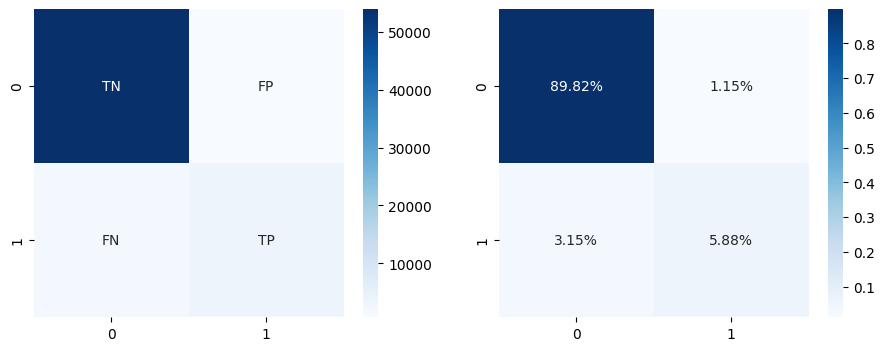

In [40]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
labels = ["TN", "FP", "FN", "TP"]
labels = np.asarray(labels).reshape(2, 2)
sn.heatmap(cm, annot=labels, cmap="Blues", fmt="", ax=axes[0])
sn.heatmap(cm / np.sum(cm), cmap="Blues", annot=True, fmt=".2%", ax=axes[1])
plt.show()

### Precision and Recall

The accuracy of the positive class is called precision.

$$
precision = \frac{TP}{TP + FP}
$$

In [31]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_predict)

np.float64(0.8370879772350012)

Precision is usually used with another metric called `recall`. This is the ration of positive instances that are correctly detected by the classifier.

$$
recall = \frac{TP}{TP + FN}
$$

In [32]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_predict)

np.float64(0.6511713705958311)

As a summary, this model ensures that 83% percents of the time when it detects a 5 is actual a 5 but only captures the 65% of the 5 found in the dataset.

### Harmonic Mean of Precision and Recall (F1-score)

It is often convinient to combine precision and recall in a single metric. For that we use F1-score. It is usuful when you want to compare different classifiers. F1-score is high when both precision and recall are high. But sometimes, we don't really need that both metrics are high but just one of them, so take than in account.

$$
F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall}
$$

In [41]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

np.float64(0.7325171197343847)

### Precision and Recall Trade-off

Some models do decision based on a threshold. Therefore, moving that threshold would change the precision and recall of the model. Scikit-Learn does not let us modify that threshold but some models have the `decision_function` method, which returns the score for each instance.

In [43]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In case the theshold is zero. The image `some_digit` is predicted as a five.

In [44]:
threshold = 0
y_scores > threshold

array([ True])

Otherwise, if we change the threshold the prediction change to not five

In [45]:
threshold = 3000
y_scores > threshold

array([False])

Now the question here is to know which is the correct threshold value to choose.

In [48]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, n_jobs=-1, verbose=3, method="decision_function"
)
y_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished


array([  4411.53413566, -14087.12193543, -21565.51993633, ...,
         9394.4695853 ,  -2918.25117218,  -9160.6081938 ])

With the scores we can use the function `precision_recall_curve` to compute the differents precision and recall per each threshold.

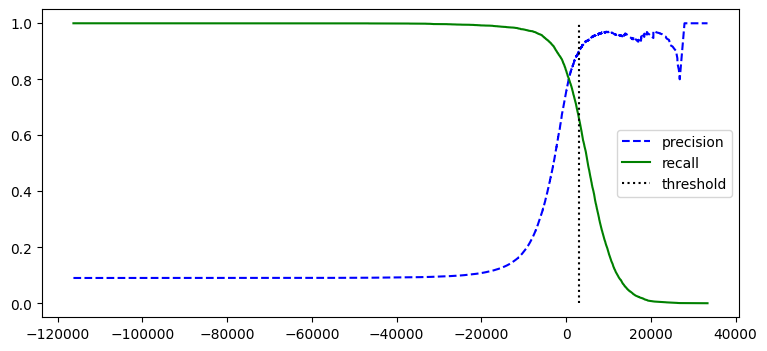

In [76]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
threshold = 3000

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="precision")
plt.plot(thresholds, recalls[:-1], "g-", label="recall")
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()
plt.show()

Another way to select a good precision/recall trade-off is to plot precision against recall.

In [77]:
idx_for_90_precision = (precisions >= 0.9).argmax()
idx_for_90_precision

np.int64(56032)

In [79]:
thresholds[idx_for_90_precision], precisions[idx_for_90_precision], recalls[
    idx_for_90_precision
]

(np.float64(3045.9258227053638),
 np.float64(0.9002016129032258),
 np.float64(0.6589190186312488))

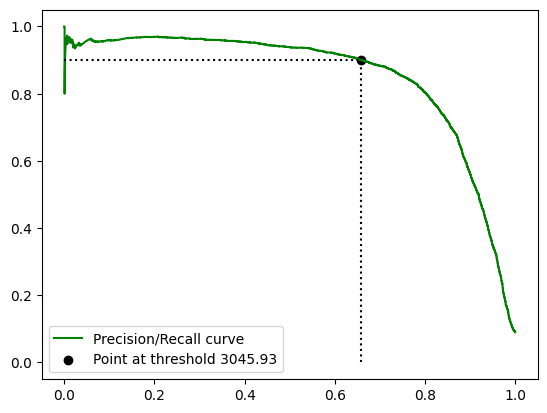

In [107]:
import matplotlib.pyplot as plt

plt.plot(recalls, precisions, "g-", label="Precision/Recall curve")
plt.scatter(
    recalls[idx_for_90_precision],
    precisions[idx_for_90_precision],
    c="black",
    label=f"Point at threshold {round(thresholds[idx_for_90_precision], 2)}",
)
plt.hlines(
    precisions[idx_for_90_precision], 0, recalls[idx_for_90_precision], "k", "dotted"
)
plt.vlines(
    recalls[idx_for_90_precision], 0, precisions[idx_for_90_precision], "k", "dotted"
)
plt.legend()
plt.show()

Now for make predictions we use this treshold, with ensures us a precision of 90%

In [109]:
y_train_pred_90_precision = y_scores > thresholds[idx_for_90_precision]

In [110]:
precision_score(y_train_5, y_train_pred_90_precision)

np.float64(0.9001764557600201)

In [111]:
recall_score(y_train_5, y_train_pred_90_precision)

np.float64(0.6587345508208817)